In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import dataprocess.data_handler_03 as dh
import simgraph.my_simgraph_06 as sg
import assessment.assess_simgraph_04_factobj1_lgrg as asg

# Check the dataset

In [2]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::16]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::10]

def transform_parham(fv):
    return fv[::5]

# data retrieval params
data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
               'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/parham/parham3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_parham, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'parham'}

In [3]:
train_num =10
val_num = 5

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=1342)

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))
print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

feature_id:  mnist-sift
train_num =  10 , val_num =  5
number of features:  16
training data contains 5 points (50.00%) of label 1.
validation data contains 2 points (40.00%) of label 1.
train_smpls =  [13088  5221  3066  9069  2026  6787 11998  6782  4016 10360] 
val_smpls =  [13095  5224  9148  3059  7592]
train_lbls =  [ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1.] 
val_lbls =  [ 1.  1. -1. -1. -1.]
train_des =  [[-0.05136574 -0.0686487   0.00784782 -0.0804113   0.09314343 -0.02251315
   0.10702582  0.00040889 -0.04412514 -0.05261263 -0.07882236  0.13128085
  -0.10208812  0.13569601 -0.04862569  0.15652375]
 [ 0.01214494  0.0596107   0.03856298  0.01258455 -0.0583704  -0.09759864
  -0.07451023 -0.09730593 -0.0377166   0.08250762 -0.01458592  0.01489668
  -0.0553671  -0.08471367 -0.05781839 -0.06755133]
 [-0.06074166 -0.08117931 -0.01991722 -0.08254311  0.05520969  0.04015224
   0.10874702  0.05102118  0.17404433 -0.02957835  0.06388069 -0.00377339
  -0.00667763 -0.10590662 -0.06735576 -0

# Assess the model's performance with random tests

In [4]:
# graph construction and penalty term parameters
sg_params = {'mu': 1, 'Dt': 20, 'Dv':2000, 'Dvt':2000, \
             'cnstr_method_tt': 'time-obj1', 'cnstr_method_vv': 'time-obj1', 'cnstr_method_vt': 'time',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                'num_its':500, 'check_freq':50, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# randomization parameters
rnd_params = {'train_sizes': [40, 45, 50, 55, 60, 65, 70, 75], 'val_sizes': [100], 'train_its': 15, 'val_its': 10, 'seed': None}

# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

# path to save the results
res_path_fact = '../../data/experiments/comparison/temp/fact/'
res_path_lgrg = '../../data/experiments/comparison/temp/lgrg/'

In [5]:
# times will be measured together and  written in res_path_sg
val_num_res_sg, val_num_err_sg, val_num_res_lgrg, val_num_err_lgrg = asg.assess_sg_model(data_params, sg_params, sg_opt_params, rnd_params, fig_params, res_path_fact, res_path_lgrg)

Number of training datapoints: 40
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 467.51
  50: eps = 2.50e-01;  train loss (E) = 199.52
 100: eps = 2.50e-01;  train loss (E) = 199.51
 150: eps = 2.50e-01;  train loss (E) = 199.51
 200: eps = 2.50e-01;  train loss (E) = 199.51
 250: eps = 1.25e-01;  train loss (E) = 199.51
 300: eps = 1.25e-01;  train loss (E) = 199.51
 350: eps = 2.50e-01;  train loss (E) = 199.51
 400: eps = 2.50e-01;  train loss (E) = 199.51
 450: eps = 1.25e-01;  train loss (E) = 199.51
 499: eps = 2.50e-01;  train loss (E) = 199.51
Number of training datapoints: 40
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 352.60
  50: eps = 2.50e-01;  train loss (E) = 236.38
 100: eps = 2.50e-01;  train loss (E) = 236.38
 150: eps = 1.25e-01;  train loss (E) = 236.38
 200: eps = 2.50e-01;  train loss (E) = 236.38
 250: eps = 2.50e-01;  train loss (E) = 236.38
 300: eps = 9.77e-04;  train loss (E) = 236

Number of training datapoints: 40
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 453.72
  50: eps = 2.50e-01;  train loss (E) = 227.72
 100: eps = 1.25e-01;  train loss (E) = 227.72
 150: eps = 1.16e-10;  train loss (E) = 227.72
 200: eps = 1.16e-10;  train loss (E) = 227.72
 250: eps = 1.16e-10;  train loss (E) = 227.72
 300: eps = 1.16e-10;  train loss (E) = 227.72
 350: eps = 1.16e-10;  train loss (E) = 227.72
 400: eps = 1.16e-10;  train loss (E) = 227.72
 450: eps = 1.16e-10;  train loss (E) = 227.72
 499: eps = 1.16e-10;  train loss (E) = 227.72
Number of training datapoints: 45
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 385.86
  50: eps = 1.25e-01;  train loss (E) = 214.96
 100: eps = 1.25e-01;  train loss (E) = 214.96
 150: eps = 2.50e-01;  train loss (E) = 214.96
 200: eps = 9.31e-10;  train loss (E) = 214.96
 250: eps = 1.16e-10;  train loss (E) = 214.96
 300: eps = 1.16e-10;  train loss (E) = 214

Number of training datapoints: 45
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 363.90
  50: eps = 2.50e-01;  train loss (E) = 182.97
 100: eps = 1.25e-01;  train loss (E) = 182.97
 150: eps = 2.50e-01;  train loss (E) = 182.97
 200: eps = 2.33e-10;  train loss (E) = 182.97
 250: eps = 2.91e-11;  train loss (E) = 182.97
 300: eps = 1.46e-11;  train loss (E) = 182.97
 350: eps = 1.46e-11;  train loss (E) = 182.97
 400: eps = 1.46e-11;  train loss (E) = 182.97
 450: eps = 1.46e-11;  train loss (E) = 182.97
 499: eps = 1.46e-11;  train loss (E) = 182.97
Number of training datapoints: 45
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 448.28
  50: eps = 1.25e-01;  train loss (E) = 230.47
 100: eps = 9.31e-10;  train loss (E) = 230.47
 150: eps = 1.16e-10;  train loss (E) = 230.47
 200: eps = 7.28e-12;  train loss (E) = 230.47
 250: eps = 7.28e-12;  train loss (E) = 230.47
 300: eps = 7.28e-12;  train loss (E) = 230

 450: eps = 2.91e-11;  train loss (E) = 258.65
 499: eps = 2.91e-11;  train loss (E) = 258.65
Number of training datapoints: 50
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 426.89
  50: eps = 2.50e-01;  train loss (E) = 245.25
 100: eps = 2.50e-01;  train loss (E) = 245.25
 150: eps = 7.45e-09;  train loss (E) = 245.25
 200: eps = 2.33e-10;  train loss (E) = 245.25
 250: eps = 5.82e-11;  train loss (E) = 245.25
 300: eps = 2.91e-11;  train loss (E) = 245.25
 350: eps = 1.46e-11;  train loss (E) = 245.25
 400: eps = 1.46e-11;  train loss (E) = 245.25
 450: eps = 1.46e-11;  train loss (E) = 245.25
 499: eps = 1.46e-11;  train loss (E) = 245.25
Number of training datapoints: 50
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 537.32
  50: eps = 2.50e-01;  train loss (E) = 240.87
 100: eps = 1.25e-01;  train loss (E) = 240.86
 150: eps = 1.25e-01;  train loss (E) = 240.86
 200: eps = 3.12e-02;  train loss (E) = 240

 350: eps = 4.66e-10;  train loss (E) = 244.75
 400: eps = 1.46e-11;  train loss (E) = 244.75
 450: eps = 1.46e-11;  train loss (E) = 244.75
 499: eps = 1.46e-11;  train loss (E) = 244.75
Number of training datapoints: 55
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 496.37
  50: eps = 1.25e-01;  train loss (E) = 207.83
 100: eps = 1.25e-01;  train loss (E) = 207.83
 150: eps = 1.16e-10;  train loss (E) = 207.83
 200: eps = 1.16e-10;  train loss (E) = 207.83
 250: eps = 1.16e-10;  train loss (E) = 207.83
 300: eps = 2.91e-11;  train loss (E) = 207.83
 350: eps = 1.46e-11;  train loss (E) = 207.83
 400: eps = 1.46e-11;  train loss (E) = 207.83
 450: eps = 1.46e-11;  train loss (E) = 207.83
 499: eps = 1.46e-11;  train loss (E) = 207.83
Number of training datapoints: 55
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 603.57
  50: eps = 1.25e-01;  train loss (E) = 267.10
 100: eps = 1.25e-01;  train loss (E) = 267

 200: eps = 1.46e-11;  train loss (E) = 247.40
 250: eps = 1.46e-11;  train loss (E) = 247.40
 300: eps = 1.46e-11;  train loss (E) = 247.40
 350: eps = 1.46e-11;  train loss (E) = 247.40
 400: eps = 1.46e-11;  train loss (E) = 247.40
 450: eps = 1.46e-11;  train loss (E) = 247.40
 499: eps = 1.46e-11;  train loss (E) = 247.40
Number of training datapoints: 60
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 430.21
  50: eps = 2.50e-01;  train loss (E) = 263.38
 100: eps = 1.25e-01;  train loss (E) = 263.38
 150: eps = 2.50e-01;  train loss (E) = 263.38
 200: eps = 1.25e-01;  train loss (E) = 263.38
 250: eps = 2.91e-11;  train loss (E) = 263.38
 300: eps = 2.91e-11;  train loss (E) = 263.38
 350: eps = 2.91e-11;  train loss (E) = 263.38
 400: eps = 2.91e-11;  train loss (E) = 263.38
 450: eps = 2.91e-11;  train loss (E) = 263.38
 499: eps = 1.16e-10;  train loss (E) = 263.38
Number of training datapoints: 60
Number of features for each point: 16
mu 

  50: eps = 2.50e-01;  train loss (E) = 290.12
 100: eps = 1.25e-01;  train loss (E) = 290.11
 150: eps = 2.50e-01;  train loss (E) = 290.11
 200: eps = 2.50e-01;  train loss (E) = 290.11
 250: eps = 1.25e-01;  train loss (E) = 290.11
 300: eps = 2.50e-01;  train loss (E) = 290.11
 350: eps = 1.16e-10;  train loss (E) = 290.11
 400: eps = 1.16e-10;  train loss (E) = 290.11
 450: eps = 2.91e-11;  train loss (E) = 290.11
 499: eps = 2.91e-11;  train loss (E) = 290.11
Number of training datapoints: 65
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 500.13
  50: eps = 1.25e-01;  train loss (E) = 259.22
 100: eps = 2.50e-01;  train loss (E) = 259.22
 150: eps = 2.33e-10;  train loss (E) = 259.22
 200: eps = 1.16e-10;  train loss (E) = 259.22
 250: eps = 1.16e-10;  train loss (E) = 259.22
 300: eps = 1.16e-10;  train loss (E) = 259.22
 350: eps = 1.16e-10;  train loss (E) = 259.22
 400: eps = 1.16e-10;  train loss (E) = 259.22
 450: eps = 1.16e-10;  train

  50: eps = 1.25e-01;  train loss (E) = 249.80
 100: eps = 1.25e-01;  train loss (E) = 249.80
 150: eps = 2.50e-01;  train loss (E) = 249.80
 200: eps = 1.25e-01;  train loss (E) = 249.80
 250: eps = 1.46e-11;  train loss (E) = 249.80
 300: eps = 1.46e-11;  train loss (E) = 249.80
 350: eps = 1.46e-11;  train loss (E) = 249.80
 400: eps = 1.46e-11;  train loss (E) = 249.80
 450: eps = 1.46e-11;  train loss (E) = 249.80
 499: eps = 1.46e-11;  train loss (E) = 249.80
Number of training datapoints: 70
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 452.30
  50: eps = 1.25e-01;  train loss (E) = 209.29
 100: eps = 1.49e-08;  train loss (E) = 209.29
 150: eps = 2.33e-10;  train loss (E) = 209.29
 200: eps = 4.66e-10;  train loss (E) = 209.29
 250: eps = 1.16e-10;  train loss (E) = 209.29
 300: eps = 1.16e-10;  train loss (E) = 209.29
 350: eps = 1.16e-10;  train loss (E) = 209.29
 400: eps = 1.16e-10;  train loss (E) = 209.29
 450: eps = 1.16e-10;  train

Number of training datapoints: 75
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 702.40
  50: eps = 1.25e-01;  train loss (E) = 281.18
 100: eps = 1.25e-01;  train loss (E) = 281.18
 150: eps = 2.33e-10;  train loss (E) = 281.18
 200: eps = 9.31e-10;  train loss (E) = 281.18
 250: eps = 1.46e-11;  train loss (E) = 281.18
 300: eps = 1.46e-11;  train loss (E) = 281.18
 350: eps = 1.46e-11;  train loss (E) = 281.18
 400: eps = 1.46e-11;  train loss (E) = 281.18
 450: eps = 1.46e-11;  train loss (E) = 281.18
 499: eps = 1.46e-11;  train loss (E) = 281.18
Number of training datapoints: 75
Number of features for each point: 16
mu = 1
   0: eps = 2.00e+00;  train loss (E) = 647.36
  50: eps = 1.25e-01;  train loss (E) = 273.32
 100: eps = 2.50e-01;  train loss (E) = 273.32
 150: eps = 9.31e-10;  train loss (E) = 273.32
 200: eps = 9.31e-10;  train loss (E) = 273.32
 250: eps = 2.33e-10;  train loss (E) = 273.32
 300: eps = 2.33e-10;  train loss (E) = 273

In [6]:
asg.plot_curves(rnd_params, sg_params, sg_opt_params, data_params['feature_id'], res_path_fact)

In [7]:
asg.plot_curves_without_runtime(rnd_params, sg_params, sg_opt_params, data_params['feature_id'], res_path_lgrg)

# Plot similarity graph and logistic regression validation accuracies together

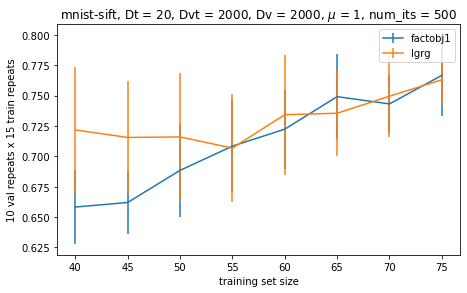

In [9]:
# unpack params
train_sizes = rnd_params['train_sizes']
val_sizes = rnd_params['val_sizes']
train_its = rnd_params['train_its']
val_its = rnd_params['val_its']
assess_qs = ['min_acc', 'val_acc', 'missed', 'false_alarm']

# read sg training curves
curves_sg = {}
errors_sg = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(res_path_fact+'curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves_sg[quantity] = curves_i[j::8].reshape((1, -1))
            errors_sg[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves_sg[quantity] = np.concatenate((curves_sg[quantity], [curves_i[j::8]]), axis=0)
            errors_sg[quantity] = np.concatenate((errors_sg[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2
        
# read lgrg training curves
curves_lgrg = {}
errors_lgrg = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(res_path_lgrg+'curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves_lgrg[quantity] = curves_i[j::8].reshape((1, -1))
            errors_lgrg[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves_lgrg[quantity] = np.concatenate((curves_lgrg[quantity], [curves_i[j::8]]), axis=0)
            errors_lgrg[quantity] = np.concatenate((errors_lgrg[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2

# plot training curves
plt.figure(figsize=(7,4))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
for i in range(len(val_sizes)):
    plt.subplot(len(val_sizes), 1, i+1)
    plt.errorbar(train_sizes, curves_sg['val_acc'][i], errors_sg['val_acc'][i])
    plt.errorbar(train_sizes, curves_lgrg['val_acc'][i], errors_lgrg['val_acc'][i])
    plt.legend(['factobj1', 'lgrg'])
    plt.xlabel('training set size')
    plt.ylabel('{} val repeats x {} train repeats'.format(val_its, train_its))
    _ = plt.title('{}, Dt = {}, Dvt = {}, Dv = {}, $\mu$ = {}, num_its = {}'.format(data_params['feature_id'], sg_params['Dt'], sg_params['Dvt'], sg_params['Dv'], sg_params['mu'], sg_opt_params['num_its']))
plt.savefig(res_path_fact+'val_acc_compare.png')